<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression</a></span></li><li><span><a href="#Visualisation-and-discretization" data-toc-modified-id="Visualisation-and-discretization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualisation and discretization</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit
import pandas as pd
from scipy import stats

# Data

In [2]:
pred = pd.read_csv("data/Cost_data_summary_V2.csv", names = ["tech", "year", "cost_ratio", "c_inv", "cap", "prod"], header = 0)
data = pd.read_csv("data/uncertainty_ranges.csv", names = ["year", "tech", "mu", "perc_5", "perc_95"], header=0)
data_electrolysis = pd.read_csv("data/uncertainty_ranges_electrolysis.csv", names = ["year", "tech", "mu", "perc_25", "perc_75"], header=0)
data_other = pd.read_csv("data/uncertainty_ranges_us.csv", names = ["year", "tech", "mu", "perc_20", "perc_80"], header=0)
hist = pd.read_csv("data/Historical_data_summary.csv", names = ["tech", "year", "c_inv", "cap"], header=0)

In [3]:
pred.replace("HYDRO_TOTAL", "HYDRO", inplace=True)
pred.replace("DEC_SOLAR", "CSP", inplace=True)
hist.replace("HYDRO_TOTAL", "HYDRO", inplace=True)
hist.replace("DEC_SOLAR", "CSP", inplace=True)

**These technologies are defined through 5th and 95th percentiles:**

In [4]:
data.tech.unique()

array(['UTILITY_PV', 'CSP', 'ONSHORE_WIND', 'OFFSHORE_WIND', 'HYDRO',
       'GEOTHERMAL'], dtype=object)

**Whereas these technologies are defined through 20th and 80th percentiles**

In [5]:
data_other.tech.unique()

array(['RES_PV', 'COMMERCIAL_PV'], dtype=object)

Now, we consider the percentile values as lower and upper bounds for the regression part, as the percentile value does not matter for the regression.

In [6]:
data.rename(columns={"perc_5":"lower", "perc_95":"upper"}, inplace=True)
data_other.rename(columns={"perc_20":"lower", "perc_80":"upper"}, inplace=True)
data = pd.concat([data, data_other])

In [7]:
pred_2050 = pred[pred.year == 2050][["tech", "cap", "c_inv"]]
pred_2050.rename(columns={"cap":"cap_2050", "c_inv":"c_inv_2050"}, inplace=True)
data = pd.merge(data, pred_2050, how = 'left', on = "tech")

In [8]:
data = pd.merge(data, hist[["tech", "year", "cap"]], on=["tech", "year"], how="inner")

In [9]:
data

,year,tech,mu,lower,upper,cap_2050,c_inv_2050,cap
0,2010,UTILITY_PV,4593,3303,7693,8014.44,371.48,8.0
1,2011,UTILITY_PV,3890,2531,7550,8014.44,371.48,18.0
2,2012,UTILITY_PV,2933,2024,6476,8014.44,371.48,30.0
3,2013,UTILITY_PV,2570,1650,5202,8014.44,371.48,51.0
4,2014,UTILITY_PV,2323,1381,5125,8014.44,371.48,76.0
...,...,...,...,...,...,...,...,...
79,2014,COMMERCIAL_PV,2828,2232,3793,4351.50,810.26,67.0
80,2013,COMMERCIAL_PV,2880,2249,3898,4351.50,810.26,57.0
81,2012,COMMERCIAL_PV,2837,2282,3695,4351.50,810.26,47.0
82,2011,COMMERCIAL_PV,4071,3511,5052,4351.50,810.26,35.0


# Regression

In [10]:
def boone(x,a,b,c):
    return(a*x**(b/(1+x/c)))

In [11]:
def sigmoid(x,a,b,c,d):
    return a/(b+np.exp(-c*x))+d

In [12]:
def plateau(x,a,b,c):
    return a+c*x**b

In [13]:
def s_curve(x,a,b,c,m):
    return c*(m+(1-m)*(x+a)**b)

In [14]:
def wright(x,a,b):
    return np.exp(a+b*np.log(x))

In [15]:
def single_regression(df, tech, func, param, p0, N_param):
    
    xm = df[df.tech == tech].cap
    ym = df[df.tech == tech][param]
    cap_2050 = df[df.tech == tech].cap_2050.iloc[0]
    c_inv_exp_2050 = df[df.tech == tech].c_inv_2050.iloc[0]
    
    if (tech == "CSP"):
        xm = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)].cap
        ym = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)][param]

    popt, pcov = curve_fit(func, xm, ym, p0 = p0, maxfev=100000)

    x = np.linspace(min(xm), cap_2050, 3000)
    plt.plot(xm, ym, marker='o', ls='none', label="historic df")
    
    if N_param == 2:
        reg = func(xm, popt[0], popt[1])
        reg_plot = func(x, popt[0], popt[1])
        c_2050 = func(cap_2050, popt[0], popt[1])
    elif N_param == 3:
        reg = func(xm, popt[0], popt[1], popt[2])
        reg_plot = func(x, popt[0], popt[1], popt[2])
        c_2050 = func(cap_2050, popt[0], popt[1], popt[2])
    elif N_param == 4:
        reg = func(xm, popt[0], popt[1], popt[2], popt[3])
        reg_plot = func(x, popt[0], popt[1], popt[2], popt[3])
        c_2050 = func(cap_2050, popt[0], popt[1], popt[2], popt[3])
    
    if (param == 'lower'):
        validity = (c_2050 < c_inv_exp_2050)
    elif (param == 'upper'):
        validity = (c_2050 > c_inv_exp_2050)
    
    plt.plot(x, reg_plot, label="regression curve")
    plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param +" 2050")
    plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050")
    plt.loglog()
    plt.grid(which = 'both')
    plt.xlabel("Cumulated capacity [GW]")
    plt.ylabel('Parameter ' + param + ' [USD_2018/kW]')
    plt.legend()
    plt.show()
    for i in range(len(p0)):
        print("Parameter " + str(i+1) + ":", popt[i])
    slope, intercept, r_value, p_value, std_err = stats.linregress(ym, reg)
    r2 = round(r_value**2, 6) 
    print("R^2 = " + str(r2))
    print("Prospective value of " + param + " in 2050:", round(c_2050, 3))
    print("Valid cost in 2050:", validity)

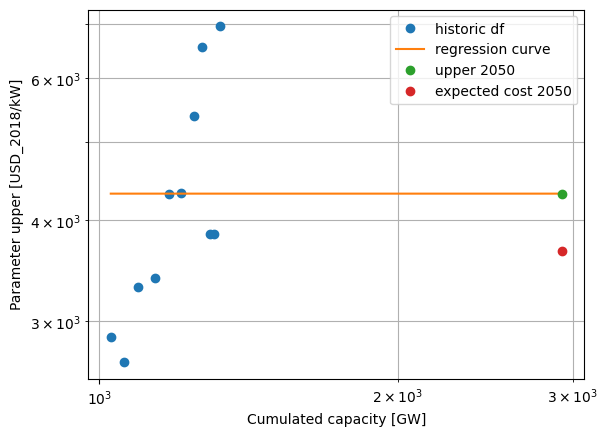

Parameter 1: -41838624.596205294
Parameter 2: -5444376.528114081
Parameter 3: 2.3697733005449035
Parameter 4: 4310.884767569266
R^2 = 0.0
Prospective value of upper in 2050: 4318.57
Valid cost in 2050: True


In [104]:
single_regression(df=data, tech="HYDRO", func = sigmoid, param = "upper", p0 = [-10000,2000,-0.01,5000], N_param=4)

In [71]:
def multiple_regressions(df, tech, funcs, p0s):
    
    N_params = []
    for i in range(len(p0s)):
        N_params.append(len(p0s[i][0]))
    
    res = pd.DataFrame(columns = ["Tech", "LC", "Parameter", "LC parameters", "Parameter 2050", "R2", "Validity"])
    
    xm = df[df.tech == tech].cap
    ym_a = df[df.tech == tech]["lower"]
    ym_b = df[df.tech == tech]["upper"]
    
    if (tech == "CSP"):
        xm = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)].cap
        ym_a = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)]["lower"]
        ym_b = df[(df.tech == tech) & (df.year != 2011) & (df.year != 2020)]["upper"]
    
    cap_2050 = df[df.tech == tech].cap_2050.iloc[0]
    c_inv_exp_2050 = df[df.tech == tech].c_inv_2050.iloc[0]
    x = np.linspace(min(xm), cap_2050, 3000)
    plt.plot(xm, ym_a, marker='o', ls='none', label="lower df", c='r')
    plt.plot(xm, ym_b, marker='o', ls='none', label="upper df", c='b')
    
    for i in range(len(funcs)):
        func = funcs[i]
        print(func.__name__)
        N_param = N_params[i]
        p0 = p0s[i]

        popt_a, pcov_a = curve_fit(func, xm, ym_a, p0 = p0[0], maxfev=100000)
        popt_b, pcov_b = curve_fit(func, xm, ym_b, p0 = p0[1], maxfev=100000)

        if N_param == 2:
            reg_a = func(xm, popt_a[0], popt_a[1])
            reg_a_plot = func(x, popt_a[0], popt_a[1])
            c_2050_a = func(cap_2050, popt_a[0], popt_a[1])
            
            reg_b = func(xm, popt_b[0], popt_b[1])
            reg_b_plot = func(x, popt_b[0], popt_b[1])
            c_2050_b = func(cap_2050, popt_b[0], popt_b[1])
            
        elif N_param == 3:
            reg_a = func(xm, popt_a[0], popt_a[1], popt_a[2])
            reg_a_plot = func(x, popt_a[0], popt_a[1], popt_a[2])
            c_2050_a = func(cap_2050, popt_a[0], popt_a[1], popt_a[2])
            
            reg_b = func(xm, popt_b[0], popt_b[1], popt_b[2])
            reg_b_plot = func(x, popt_b[0], popt_b[1], popt_b[2])
            c_2050_b = func(cap_2050, popt_b[0], popt_b[1], popt_b[2])
            
        elif N_param == 4:
            reg_a = func(xm, popt_a[0], popt_a[1], popt_a[2], popt_a[3])
            reg_a_plot = func(x, popt_a[0], popt_a[1], popt_a[2], popt_a[3])
            c_2050_a = func(cap_2050, popt_a[0], popt_a[1], popt_a[2], popt_a[3])
            
            reg_b = func(xm, popt_b[0], popt_b[1], popt_b[2], popt_b[3])
            reg_b_plot = func(x, popt_b[0], popt_b[1], popt_b[2], popt_b[3])
            c_2050_b = func(cap_2050, popt_b[0], popt_b[1], popt_b[2], popt_b[3])

        validity_a = (c_2050_a < c_inv_exp_2050)
        validity_b = (c_2050_b > c_inv_exp_2050)
        
        r_value_a = stats.linregress(ym_a, reg_a)[2]
        r_value_b = stats.linregress(ym_b, reg_b)[2]
        R2_a = round(r_value_a**2, 4) 
        R2_b = round(r_value_b**2, 4) 
        
        res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
        res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
        
        color_a = (1-0.1*(i+1), 0.2*(i+1), 0)
        color_b = (0, 0.2*(i+1), 1-0.1*(i+1))
        plt.plot(x, reg_a_plot, label=func.__name__+" a", c = color_a)
        plt.plot(x, reg_b_plot, label=func.__name__+" b", c = color_b)
        #plt.plot(cap_2050, c_2050_a, marker='o', ls='none')
        #plt.plot(cap_2050, c_2050_b, marker='o', ls='none')
        
        plt.xlabel("Cumulated capacity [GW]")
        plt.ylabel('Lower & upper [USD_2018/kW]')
        
#         for i in range(len(p0)):
#             print("Parameter " + str(i+1) + ":", popt[i])
#         slope, intercept, r_value, p_value, std_err = stats.linregress(ym, reg)
#         r2 = round(r_value**2, 4) 
#         print("R^2 = " + str(r2))
#         print("Prospective value of " + param + " in 2050:", round(c_2050, 3))
        
    plt.loglog()
    plt.grid(which = 'both')
    plt.legend()
    plt.show()
    
    return(res)

wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


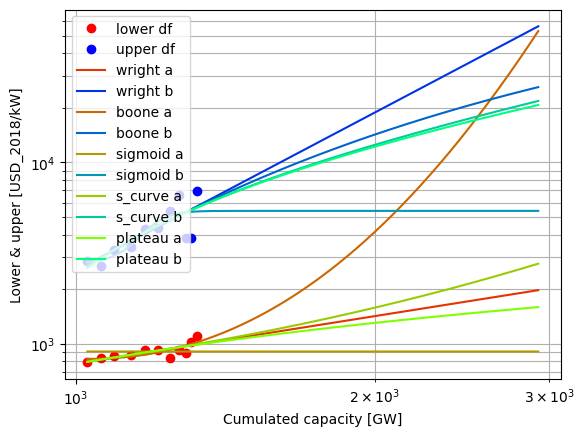

In [76]:
hydro = multiple_regressions(df = data,
                             tech="HYDRO", 
                             funcs=[wright,
                                    boone, 
                                    sigmoid, 
                                    s_curve,
                                    plateau],
                             p0s = [[[10, -1], [10, -1]],
                                    [[30, 500, 1], [30, 500, 1]], 
                                    [[-2000,10,0.0001,20000], [-60000,20,-0.0001,2000]], 
                                    [[-100,1,0.1,0.001], [-100,1,0.1,0.001]],
                                    [[1000,-0.1,10000], [1000,-0.1,10000]]])

In [77]:
hydro

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,HYDRO,wright,lower,"[0.6478152297121165, 0.8695346611967717]",1973.013406,0.5873,True
1,HYDRO,wright,upper,"[-12.107896955724502, 2.8878230971534316]",56329.599446,0.5413,True
2,HYDRO,boone,lower,"[1.3638496833079515e+23, -7.832788712431464, 6...",53013.307259,0.6308,False
3,HYDRO,boone,upper,"[121218.1074024912, -5585.72963788261, 0.10092...",26021.866744,0.5431,True
4,HYDRO,sigmoid,lower,"[-76311.00921759872, 331.39268898766966, -0.04...",905.272727,0.0,True
5,HYDRO,sigmoid,upper,"[-1.918485480286167e+17, 72864557464363.2, -0....",5402.484746,0.5537,True
6,HYDRO,s_curve,lower,"[4439.489722739, 4.173834701494343, 1.41624241...",2762.365194,0.5953,True
7,HYDRO,s_curve,upper,"[-769.3489267940266, 0.9965518264743662, 1.013...",21825.012735,0.5439,True
8,HYDRO,plateau,lower,"[446323.09033096937, -0.0017149420764112598, -...",1591.512566,0.5786,True
9,HYDRO,plateau,upper,"[-9588.221859427184, 0.8700891528907257, 29.24...",20737.263839,0.5439,True


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


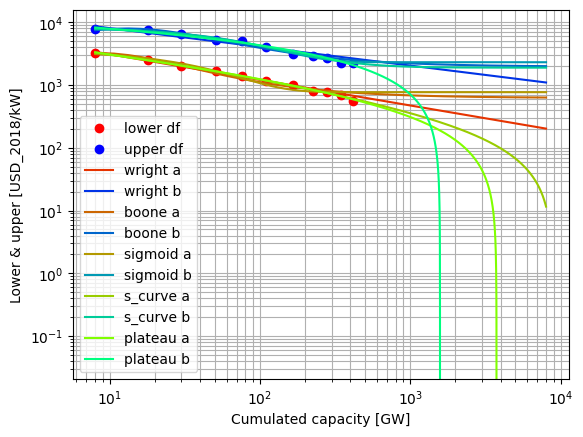

In [106]:
utility_pv = multiple_regressions(df= data, tech="UTILITY_PV", 
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[3000, 500, 0.1], [3000, 500, 0.1]], 
                            [[-100000,100,0.01,10000], [-100000,100,0.01,10000]], 
                            [[10,-1,10000,0.001], [10,-1,10000,0.001]],
                            [[10,-0.1,10000], [10,-0.1,10000]]])

In [107]:
utility_pv

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,UTILITY_PV,wright,lower,"[8.977344787767247, -0.40789779382304486]",202.50234,0.9946,True
1,UTILITY_PV,wright,upper,"[9.683905455710413, -0.29823969107363935]",1099.959692,0.9263,True
2,UTILITY_PV,boone,lower,"[623.9683073342308, 1.479351478872674, 9.26313...",633.621396,0.9841,False
3,UTILITY_PV,boone,upper,"[1962.701970989959, 0.9028118236554293, 19.965...",2002.685426,0.9797,True
4,UTILITY_PV,sigmoid,lower,"[-6217639027.057975, 1485.5446853808992, 0.022...",770.652653,0.9741,False
5,UTILITY_PV,sigmoid,upper,"[-3060237246.9056892, 713.5647370948985, 0.011...",2313.658038,0.9876,True
6,UTILITY_PV,s_curve,lower,"[2.4413714283267725, -0.38037026146267605, 847...",11.583741,0.9989,True
7,UTILITY_PV,s_curve,upper,"[202.89546865584077, -2.594716799545682, 64064...",1896.346327,0.9887,True
8,UTILITY_PV,plateau,lower,"[-655.0165405495583, -0.2931752744733445, 7313...",-130.683169,0.9987,True
9,UTILITY_PV,plateau,upper,"[-11102923.845626378, -0.00014063500124934032,...",-2537.188912,0.9738,False


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


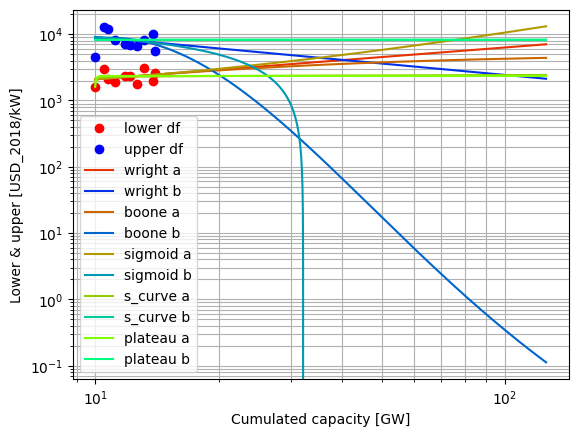

In [108]:
geothermal = multiple_regressions(tech="GEOTHERMAL", df=data,
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[3000, 500, 0.1], [3000, 500, 0.1]], 
                            [[30000,0.0001,0.2,-200000], [30000,0.0001,0.2,-200000]], 
                            [[10,1,10,0.1], [10,1,10,0.1]],
                            [[100000,-0.1,10000], [100000,-0.1,10000]]])

In [109]:
geothermal

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,GEOTHERMAL,wright,lower,"[6.536966928985496, 0.48039738279970895]",7046.625294,0.0676,False
1,GEOTHERMAL,wright,upper,"[10.431751371092394, -0.5724616001467973]",2128.484902,0.0431,False
2,GEOTHERMAL,boone,lower,"[5103.515785480107, 775.7967449890003, -0.0050...",4395.537881,0.0681,True
3,GEOTHERMAL,boone,upper,"[0.00013839896721496055, 12.96846913031156, 15...",0.112269,0.0611,False
4,GEOTHERMAL,sigmoid,lower,"[111011.36559978314, -0.15829664442856467, 0.0...",13150.709128,0.0667,False
5,GEOTHERMAL,sigmoid,upper,"[293633.7240289053, 0.036635105714282724, -0.0...",-35273.405453,0.0461,False
6,GEOTHERMAL,s_curve,lower,"[-9.991999971961276, 0.0003561336411818151, 22...",2428.188256,0.2048,True
7,GEOTHERMAL,s_curve,upper,"[22225.110617081642, 0.007127691349868101, 137...",8229.099989,0.0461,True
8,GEOTHERMAL,plateau,lower,"[2346.6753298936296, -159.5105517521393, -2.09...",2346.67533,0.2155,True
9,GEOTHERMAL,plateau,upper,"[8225.500000163516, -8.933097177694002, -425.2...",8225.5,0.0082,True


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


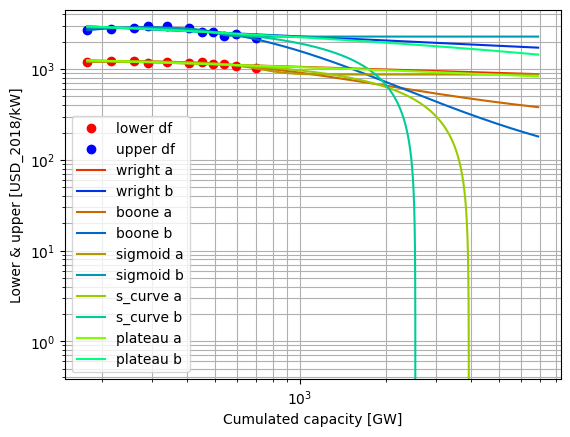

In [110]:
onshore_wind = multiple_regressions(tech="ONSHORE_WIND", df=data,
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[300, 0.5, 1000], [300, 0.5, 1000]], 
                            [[500,0.01,0.01,5000], [-1000,0.1,0.01,1000]], 
                            [[10,-1,10000,0.001], [10,-1,10000,0.001]],
                            [[10000,-0.1,10000], [10000,-0.1,10000]]])

In [111]:
onshore_wind

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,ONSHORE_WIND,wright,lower,"[7.627179885819809, -0.09591362911626614]",879.547128,0.642,False
1,ONSHORE_WIND,wright,upper,"[8.755138787263599, -0.14743284188480696]",1723.292413,0.4805,True
2,ONSHORE_WIND,boone,lower,"[239.7239093920596, 0.3567219087002119, 1187.3...",380.909139,0.8811,True
3,ONSHORE_WIND,boone,upper,"[52.44050762226633, 0.8605764306187003, 1340.4...",180.796759,0.8877,False
4,ONSHORE_WIND,sigmoid,lower,"[-0.5488500649027156, 0.0016063277148084835, 0...",871.653907,0.9376,False
5,ONSHORE_WIND,sigmoid,upper,"[-0.001616127356831031, 2.84642834522289e-06, ...",2282.129991,0.8434,True
6,ONSHORE_WIND,s_curve,lower,"[319175.99201537226, -0.061073739857062305, 20...",-969.663048,0.7918,True
7,ONSHORE_WIND,s_curve,upper,"[362201.3259766477, -0.10181047242719443, 1187...",-5336.36147,0.6525,False
8,ONSHORE_WIND,plateau,lower,"[-546986.1498996875, -0.00020938754215555272, ...",829.724458,0.6563,True
9,ONSHORE_WIND,plateau,upper,"[-1637758.841369578, -0.0002529269858859508, 1...",1444.332317,0.505,True


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


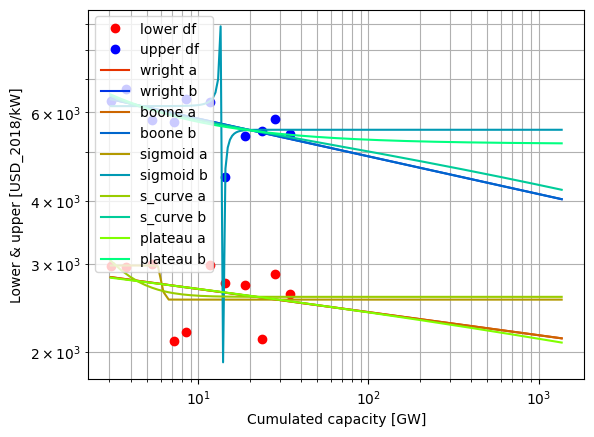

In [112]:
offshore_wind = multiple_regressions(tech="OFFSHORE_WIND", df=data,
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[300, 0.5, 1000], [300, 0.5, 1000]], 
                            [[500,0.01,0.01,5000], [-1000,0.1,0.01,1000]], 
                            [[1000,-1,1000000,0.001], [20000,0.5,10000,0.5]],
                            [[10000,0.1,10000], [10000,0.1,10000]]])

In [113]:
offshore_wind

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,OFFSHORE_WIND,wright,lower,"[7.995791885552757, -0.04594963371501823]",2130.266902,0.0769,False
1,OFFSHORE_WIND,wright,upper,"[8.843234364794876, -0.07502992065597387]",4029.769658,0.3302,True
2,OFFSHORE_WIND,boone,lower,"[2968.4398129556585, -0.045949586961816676, -1...",2130.261661,0.0769,False
3,OFFSHORE_WIND,boone,upper,"[6927.361267956552, -0.07502986137259435, -123...",4029.74671,0.3302,True
4,OFFSHORE_WIND,sigmoid,lower,"[-9.3577633388334e-29, 2.1765763660077454e-31,...",2543.750335,0.3188,False
5,OFFSHORE_WIND,sigmoid,upper,"[0.008726912166382926, -1.3787840154127189e-05...",5538.654467,0.804,True
6,OFFSHORE_WIND,s_curve,lower,"[4.781823167675105, -5.612513088235923, 482017...",2576.202915,0.1809,False
7,OFFSHORE_WIND,s_curve,upper,"[-2.194721218840692, 0.00024651006824470895, 6...",4207.361184,0.3385,True
8,OFFSHORE_WIND,plateau,lower,"[788763.2437473842, 0.00015058049773996086, -7...",2089.444188,0.0742,False
9,OFFSHORE_WIND,plateau,upper,"[5190.076466190205, -0.7335215925028227, 2993....",5205.06875,0.3525,True


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


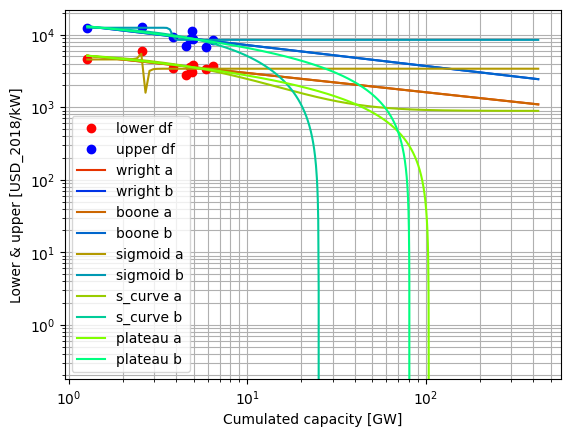

In [114]:
csp = multiple_regressions(tech="CSP", df=data,
                     funcs=[wright,
                            boone, 
                            sigmoid, 
                            s_curve,
                            plateau],
                     p0s = [[[10, -1], [10, -1]],
                            [[300, 0.5, 1000], [300, 0.5, 1000]], 
                            [[-2000,5,0.5,5000], [-200000,5,0.05,50000]], 
                            [[20,-2,1000000,0.01], [20,-2,1000000,0.01]],
                            [[10000,-0.1,10000], [10000,-0.1,10000]]])

In [115]:
csp

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,CSP,wright,lower,"[8.603694858249815, -0.26544944029924444]",1092.853367,0.3446,True
1,CSP,wright,upper,"[9.541114808152601, -0.28809273244023503]",2432.986596,0.5247,True
2,CSP,boone,lower,"[5451.759004745396, -0.2654483989055316, 31427...",1092.882677,0.3446,True
3,CSP,boone,upper,"[13920.412404416093, -0.2880900680305632, 7240...",2433.042911,0.5247,True
4,CSP,sigmoid,lower,"[2.6678871146977017e-08, -2.3061658567857813e-...",3392.145098,0.8815,False
5,CSP,sigmoid,upper,"[-4.4475741061219047e-26, 1.1194032005896663e-...",8477.335122,0.6561,True
6,CSP,s_curve,lower,"[20.736180969769695, -2.9790851924859565, 4207...",889.59694,0.3924,True
7,CSP,s_curve,upper,"[117.2479574316071, -9.869982708625434, 4.4808...",-2503.217471,0.5793,False
8,CSP,plateau,lower,"[-3990523.3705974626, -0.0002925067983075151, ...",-1649.052697,0.3626,True
9,CSP,plateau,upper,"[-8431775.810367294, -0.0003715030463339857, 8...",-5205.577277,0.5471,False


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

plateau


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


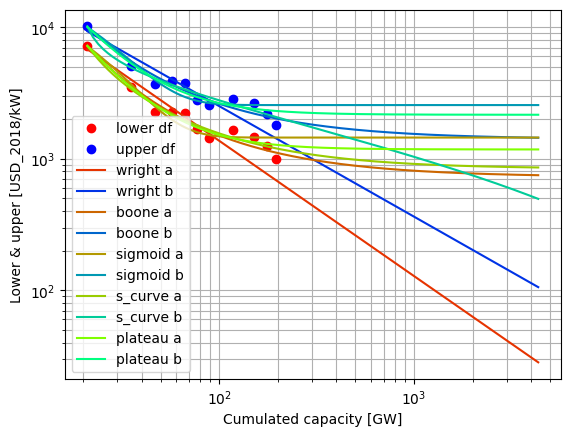

In [116]:
commercial_pv = multiple_regressions(df=data,
                                     tech="COMMERCIAL_PV", 
                                     funcs=[wright,
                                            boone, 
                                            sigmoid, 
                                            s_curve,
                                            plateau],
                                     p0s = [[[10, -1], [10, -1]],
                                            [[900, 7000, 0.001], [900, 7000, 0.001]], 
                                            [[-200000,1,0.05,50000], [-200000,1,0.05,50000]], 
                                            [[-20,-0.2,10000,0.01], [-20,-0.2,20000,0.05]],
                                            [[10000,-0.1,10000], [10000,-0.1,10000]]])

In [117]:
commercial_pv

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,COMMERCIAL_PV,wright,lower,"[11.955505401389168, -1.0279298453871282]",28.310296,0.944,True
1,COMMERCIAL_PV,wright,upper,"[11.697623944023851, -0.8400286765075464]",105.597208,0.9151,False
2,COMMERCIAL_PV,boone,lower,"[727.352910949043, 154200.70132858804, 0.00010...",749.789378,0.9869,True
3,COMMERCIAL_PV,boone,upper,"[1407.3692257993744, 132364.86675802618, 0.000...",1444.408976,0.9732,True
4,COMMERCIAL_PV,sigmoid,lower,"[-2164590217.8011065, 307.84951742130187, 0.06...",1449.518857,0.977,False
5,COMMERCIAL_PV,sigmoid,upper,"[-2571816976.497986, 297.72822098910393, 0.064...",2560.118913,0.9573,True
6,COMMERCIAL_PV,s_curve,lower,"[-12.536958044270719, -0.9366405039031352, 481...",858.411982,0.9895,False
7,COMMERCIAL_PV,s_curve,upper,"[-19.099132510553243, -0.32078685924903555, 12...",495.449819,0.9827,False
8,COMMERCIAL_PV,plateau,lower,"[1176.9239608956163, -1.8410676099768581, 1642...",1177.252482,0.9881,False
9,COMMERCIAL_PV,plateau,upper,"[2160.5541835250524, -1.7819173074382457, 1799...",2161.144855,0.9756,True


wright
boone


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i

sigmoid


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


s_curve


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


plateau


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:68: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i] = np.array([tech, func.__name__, "lower", popt_a.ravel(), c_2050_a, R2_a, validity_a], dtype=object)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_7876\1468547410.py:69: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  res.loc[2*i+1] = np.array([tech, func.__name__, "upper", popt_b.ravel(), c_2050_b, R2_b, validity_b], dtype=object)


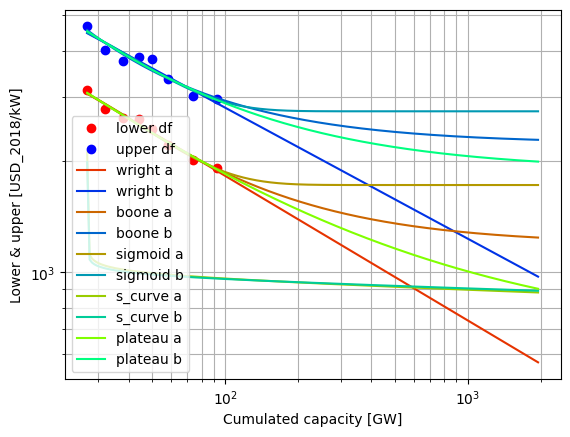

In [118]:
res_pv = multiple_regressions(df=data,
                             tech="RES_PV", 
                             funcs=[wright,
                                    boone, 
                                    sigmoid, 
                                    s_curve,
                                    plateau],
                             p0s = [[[10, -1], [10, -1]],
                                    [[900, 7000, 0.001], [900, 7000, 0.001]], 
                                    [[-200000,1,0.05,50000], [-200000,1,0.05,50000]], 
                                    [[-20,-0.2,600,0.1], [-20,-0.2,600,0.1]],
                                    [[1000,-0.1,50000], [1000,-0.1,50000]]])

In [119]:
res_pv

,Tech,LC,Parameter,LC parameters,Parameter 2050,R2,Validity
0,RES_PV,wright,lower,"[9.318445878820475, -0.39238903894420696]",569.695251,0.9746,True
1,RES_PV,wright,upper,"[9.574666050050679, -0.3555053357671877]",973.414059,0.9138,True
2,RES_PV,boone,lower,"[1192.4812708706775, 1.0414426549116633, 10.26...",1242.687573,0.9744,False
3,RES_PV,boone,upper,"[2238.527188725438, 7607.296158414625, 0.00076...",2289.51491,0.9168,True
4,RES_PV,sigmoid,lower,"[-94466526.67586708, 177.1377788712587, 0.0301...",1725.907643,0.9738,False
5,RES_PV,sigmoid,upper,"[-260981455.84871706, 248.29644325083464, 0.03...",2736.421021,0.9114,True
6,RES_PV,s_curve,lower,"[-26.99999979613485, -0.0702087196400279, 1098...",881.624963,0.4941,False
7,RES_PV,s_curve,upper,"[-26.999999987175016, -0.056461386473074214, 1...",891.102051,0.562,True
8,RES_PV,plateau,lower,"[663.3991920980678, -0.5396909706869634, 14262...",902.260904,0.9753,False
9,RES_PV,plateau,upper,"[1890.6926428430968, -0.7463041906494959, 3069...",1998.119866,0.918,True


In [120]:
results = pd.concat([utility_pv, res_pv, commercial_pv, csp, onshore_wind, offshore_wind, geothermal, hydro])

In [121]:
results.to_excel("percentiles_regressions.xlsx", index=False)

# Visualisation and discretization

In [78]:
font = {'family' : 'Times New Roman',
        'size'   : 20}

plt.rc('font', **font)
plt.rcParams.update({'mathtext.default':  'regular' })

In [79]:
results = pd.DataFrame(columns=["tech", "year", "cap", "c_inv", "c_inv_low", "c_inv_high"])

In [80]:
data_pred = pred[pred.year > 2020]

In [81]:
data_pred

,tech,year,cost_ratio,c_inv,cap,prod
3,RES_PV,2021,0.692,1872.68,150.67,NaN
4,RES_PV,2022,0.606,1639.53,208.35,NaN
5,RES_PV,2023,0.548,1483.13,266.02,NaN
6,RES_PV,2024,0.506,1368.42,323.70,NaN
7,RES_PV,2025,0.473,1279.39,381.37,NaN
...,...,...,...,...,...,...
523,GEOTHERMAL,2046,1.615,6617.58,114.80,NaN
524,GEOTHERMAL,2047,1.619,6634.81,117.60,NaN
525,GEOTHERMAL,2048,1.623,6651.39,120.40,NaN
526,GEOTHERMAL,2049,1.627,6667.36,123.20,NaN


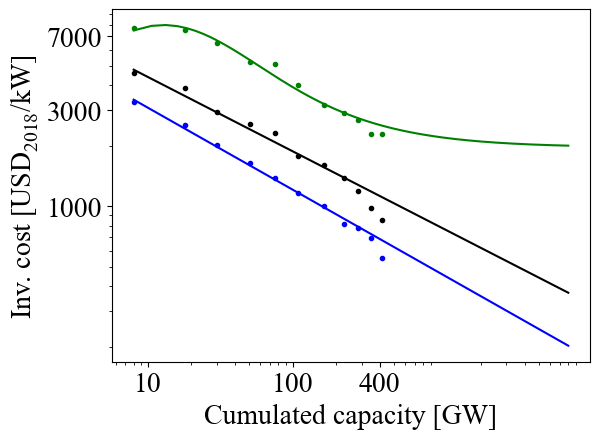

In [82]:
tech = "UTILITY_PV"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

#plt.figure(figsize=(14,3))
plt.plot(xm, ym, marker='.', ls='none', c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', c=color_b)

reg = wright(x=x,a=9.2415,b=-0.36979)
reg_a = wright(x=x, a=8.97734479, b=-0.40789779)
reg_b = boone(x=x, a=1.96270197e+03, b=9.02811824e-01, c=1.99656999e+01)

cap_pred = np.array(data_pred[data_pred.tech == tech].cap)
c_inv_low = wright(x=cap_pred, a=8.97734479, b=-0.40789779)
c_inv_high = boone(x=cap_pred, a=1.96270197e+03, b=9.02811824e-01, c=1.99656999e+01)
c_inv = data_pred[data_pred.tech == tech].c_inv

df = data_pred[data_pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

#plt.plot(cap_pred, c_inv_low, marker="|",color=color_a, ms=10, ls='none')
#plt.plot(cap_pred, c_inv_high, marker="|",color=color_b, ms=10, ls='none')
#plt.plot(cap_pred, c_inv, marker="|",color=color_main, ms=10, label="Prospective data", ls='none')
plt.plot(x, reg, c=color_main, label="Nominal value")
plt.plot(x, reg_a, c=color_a, label="Lower perc.")
plt.plot(x, reg_b, c=color_b, label="Higher perc.")

# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
yticks=[1000, 3000, 7000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[10, 100, 400]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

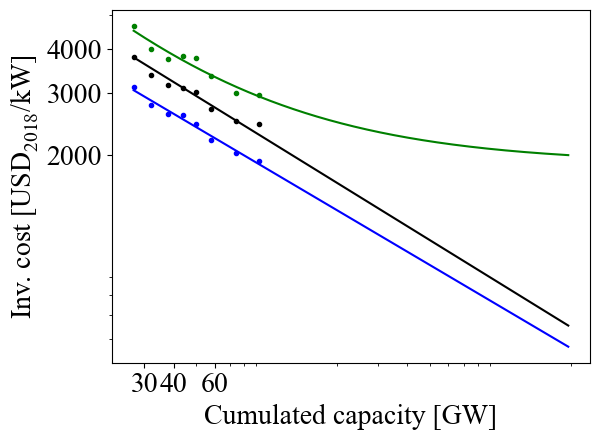

In [83]:
tech = "RES_PV"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = wright(x=x,a=9.5926, b=-0.41030)
reg_a = wright(x=x, a=9.31844588, b=-0.39238904)
reg_b = plateau(x=x, a=1.89069264e+03, b=-7.46304191e-01, c=3.06983675e+04)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
yticks=[2000, 3000, 4000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[30, 40, 60]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [84]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = wright(x=cap_pred, a=9.31844588, b=-0.39238904)
c_inv_high = plateau(x=cap_pred, a=1.89069264e+03, b=-7.46304191e-01, c=3.06983675e+04)

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

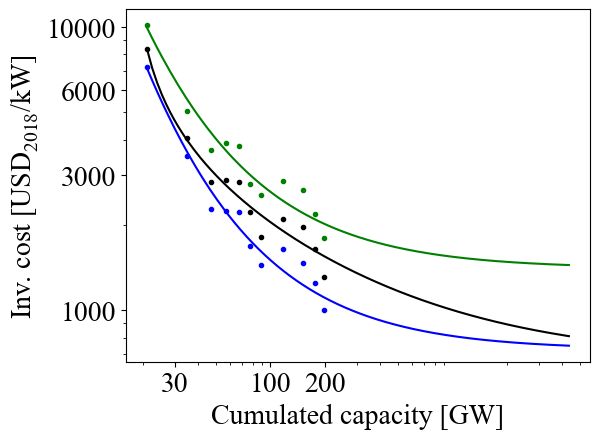

In [86]:
tech = "COMMERCIAL_PV"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = s_curve(x=x, a = -16.8468, b = -0.574336, c = 18146.3, m = 0.0368012)
reg_a = boone(x=x, a=7.27352911e+02, b=1.54200701e+05, c=1.02327773e-04)
reg_b = boone(x=x, a=1.40736923e+03, b=1.32364867e+05, c=1.01933829e-04)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
yticks=[1000, 3000, 6000, 10000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[30, 100, 200]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [87]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = boone(x=cap_pred, a=7.27352911e+02, b=1.54200701e+05, c=1.02327773e-04)
c_inv_high = boone(x=cap_pred, a=1.40736923e+03, b=1.32364867e+05, c=1.01933829e-04)

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

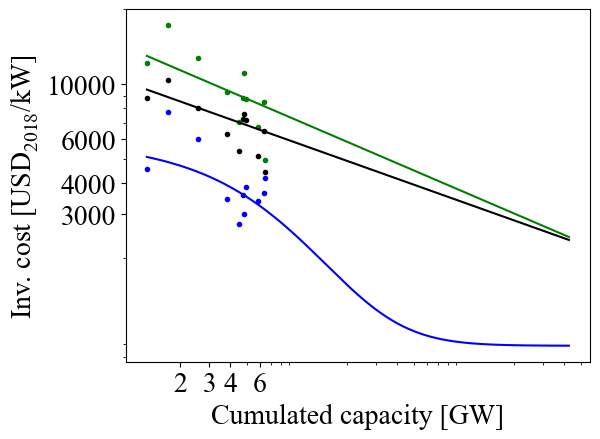

In [107]:
tech = "CSP"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = wright(x=x,a=9.2176, b=-0.23914)
reg_a = s_curve(x=x, a=2.07361810e+01, b=-2.97908519e+00, c=4.20730087e+07, m=2.11313819e-05)
reg_b = wright(x=x, a=9.54111481, b=-0.28809273)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
yticks=[3000, 4000, 6000, 10000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[2, 3, 4, 6]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [108]:
reg_a

array([5102.86751462, 5023.08746737, 4945.31216948, ...,  889.5979538 ,
        889.59744651,  889.59693985])

In [91]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = s_curve(x=cap_pred, a=2.07361810e+01, b=-2.97908519e+00, c=4.20730087e+07, m=2.11313819e-05)
c_inv_high = wright(x=cap_pred, a=9.54111481, b=-0.28809273)

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

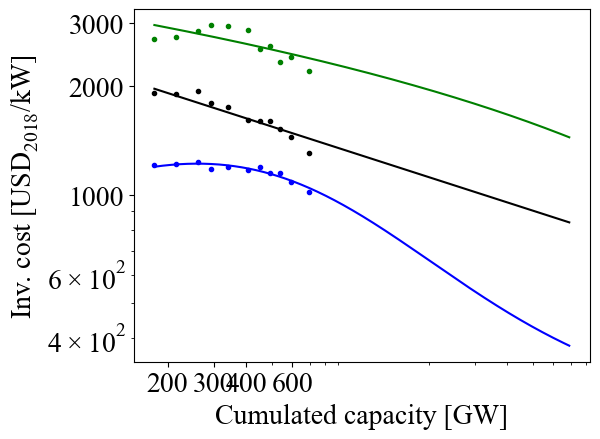

In [92]:
tech = "ONSHORE_WIND"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = wright(x=x,a=8.7969,b=-0.2337)
reg_a = boone(x=x, a=2.39723909e+02, b=3.56721909e-01, c=1.18739888e+03)
reg_b = plateau(x=x, a=-1.63775884e+06, b=-2.52926986e-04, c=1.64287188e+06)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
yticks=[1000, 2000, 3000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[200, 300, 400, 600]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [93]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = boone(x=cap_pred, a=2.39723909e+02, b=3.56721909e-01, c=1.18739888e+03)
c_inv_high = plateau(x=cap_pred, a=-1.63775884e+06, b=-2.52926986e-04, c=1.64287188e+06)

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

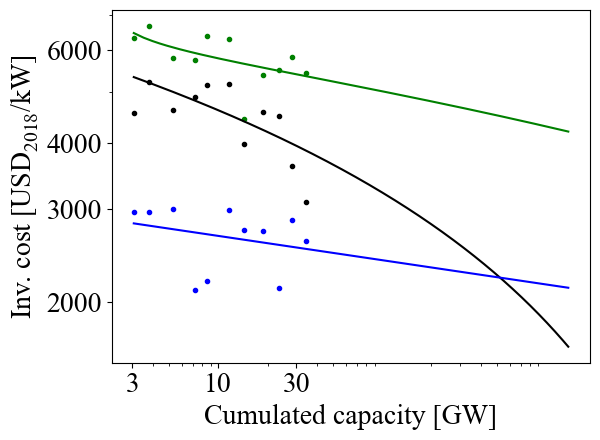

In [94]:
tech = "OFFSHORE_WIND"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = plateau(x=x,a = -2849200, b = -0.000211753, c = 2855210)
reg_a = wright(x=x, a=7.99579189, b=-0.04594963)
reg_b = s_curve(x=x, a=-2.19472122e+00, b=2.46510068e-04, c=6.41783582e+03, m=1.94371311e+02)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
#plt.plot(x, 3000*[0.95*c_inv_exp_2050],c=color_a)

# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
#plt.grid()
yticks=[2000, 3000, 4000, 6000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[3, 10, 30]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [95]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = wright(x=cap_pred, a=7.99579189, b=-0.04594963)
c_inv_high = s_curve(x=cap_pred, a=-2.19472122e+00, b=2.46510068e-04, c=6.41783582e+03, m=1.94371311e+02)

max_low_over_nom_ratio = max(ym_a/ym)

for i in range(len(c_inv_low)):
    if (max_low_over_nom_ratio*pred[pred.tech == tech].c_inv.iloc[i] >= c_inv_low[i]):
        print(pred[pred.tech == tech].cap.iloc[i])
        pass
    else:
        c_inv_low[i] = max_low_over_nom_ratio*pred[pred.tech == tech].c_inv.iloc[i]

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

23.626
28.355
34.367
66.02
97.67
129.32
160.97
192.62


In [96]:
print(max_low_over_nom_ratio)

0.8444372574385511


In [97]:
print(c_inv_low[-1])

1391.374202457956


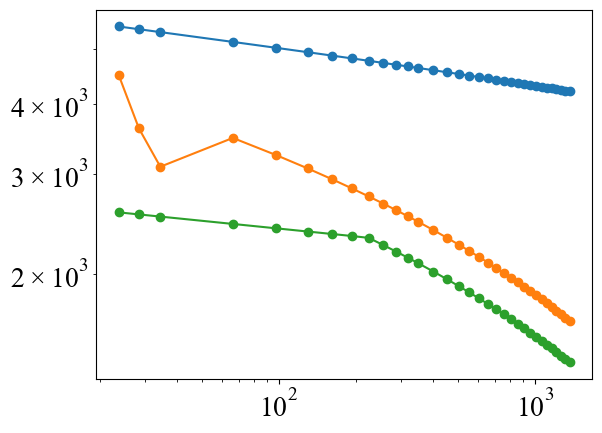

In [98]:
plt.plot(cap_pred, c_inv_high, marker="o")
plt.plot(cap_pred, pred[pred.tech == tech].c_inv,marker="o")
plt.plot(cap_pred, c_inv_low, marker="o")
plt.loglog()
plt.show()

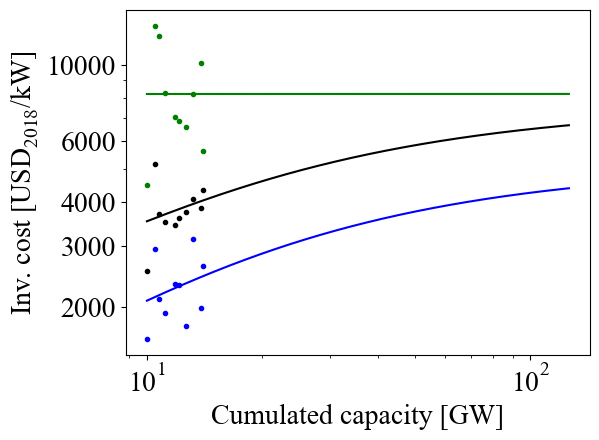

In [100]:
tech = "GEOTHERMAL"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = boone(x=x,a=7597.11,b=-81.6475,c=0.0409338)
reg_a = boone(x=x, a=5.10351579e+03,  b=7.75796745e+02, c=-5.01497945e-03)
reg_b = s_curve(x=x, a=2.22251106e+04,  b=7.12769135e-03,  c=1.37763124e+03, m=-6.62162715e+01)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
yticks=[2000, 3000, 4000, 6000, 10000]
plt.yticks(ticks=yticks, labels=yticks)
xticks=[10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14]
#plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [101]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = boone(x=cap_pred, a=5.10351579e+03,  b=7.75796745e+02, c=-5.01497945e-03)
c_inv_high = s_curve(x=cap_pred, a=2.22251106e+04,  b=7.12769135e-03,  c=1.37763124e+03, m=-6.62162715e+01)

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

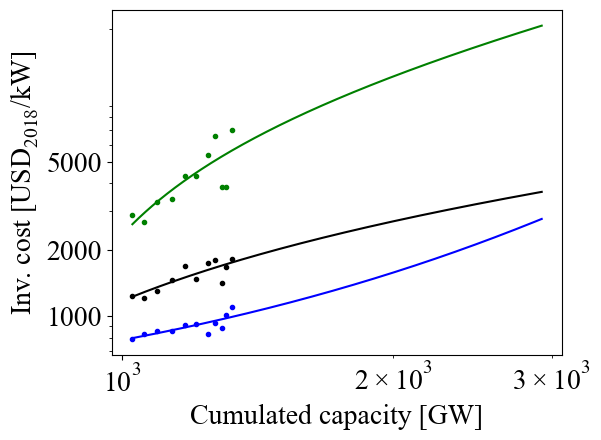

In [105]:
tech = "HYDRO"
color_main = "black"
color_a = "blue"
color_b = "green"
xm = data[data.tech == tech].cap
ym = data[data.tech == tech]["mu"]
ym_a = data[data.tech == tech]["lower"]
ym_b = data[data.tech == tech]["upper"]
cap_2020 = data[(data.tech == tech) & (data.year == 2020)].cap
cap_2050 = data[data.tech == tech].cap_2050.iloc[0]
c_inv_exp_2050 = data[data.tech == tech].c_inv_2050.iloc[0]
x = np.linspace(min(xm), cap_2050, 3000)

plt.plot(xm, ym, marker='.', ls='none', label="historic mean", c=color_main)
plt.plot(xm, ym_a, marker='.', ls='none', label="historic lower perc.", c=color_a)
plt.plot(xm, ym_b, marker='.', ls='none', label="historic higher perc.", c=color_b)

reg = plateau(x=x,a=-5750.07,b=0.286223,c=958.715)
reg_a = s_curve(x=x, a=4.43948972e+03, b=4.17383470e+00, c=1.41624242e-07, m=9.99998589e-01)
reg_b = plateau(x=x, a=-9.58822186e+03,  b=8.70089153e-01,  c=2.92481535e+01)

plt.plot(x, reg, c=color_main)
plt.plot(x, reg_a, c=color_a)
plt.plot(x, reg_b, c=color_b)
# plt.plot(cap_2050, c_2050, marker='o', ls='none', label = param+" 2050")
#plt.plot(cap_2050, c_inv_exp_2050, marker = 'o', ls='none', label = "expected cost 2050", c=color_main)
plt.loglog()
yticks=[1000, 2000, 5000]
plt.yticks(ticks=yticks, labels=yticks)
#xticks=[1050, 1100, 1150, 1200, 1250, 1300]
#plt.xticks(ticks=xticks, labels=xticks)
plt.xlabel("Cumulated capacity [GW]")
plt.ylabel('Inv. cost [USD$_{2018}$/kW]')
#plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig("pics/3_LCs_"+tech+".pdf", format="pdf")
plt.show()

In [103]:
cap_pred = np.array(pred[pred.tech == tech].cap)
c_inv_low = s_curve(x=cap_pred, a=4.43948972e+03, b=4.17383470e+00, c=1.41624242e-07, m=9.99998589e-01)
c_inv_high = plateau(x=cap_pred, a=-9.58822186e+03,  b=8.70089153e-01,  c=2.92481535e+01)

df = pred[pred.tech == tech][["tech", "year", "c_inv", "cap"]]
df["c_inv_low"] = c_inv_low
df["c_inv_high"] = c_inv_high

results = pd.concat([results, df])

In [62]:
results

,tech,year,cap,c_inv,c_inv_low,c_inv_high
432,UTILITY_PV,2021,648.22,941.44,564.827640,2337.247013
433,UTILITY_PV,2022,881.45,840.31,498.277961,2247.751862
434,UTILITY_PV,2023,1114.67,770.44,452.779815,2194.130860
435,UTILITY_PV,2024,1347.89,718.17,419.017509,2158.222342
436,UTILITY_PV,2025,1581.12,677.02,392.609333,2132.400611
...,...,...,...,...,...,...
358,HYDRO,2046,2745.00,3494.34,2492.434489,19115.410119
359,HYDRO,2047,2789.75,3537.23,2557.875049,19522.128660
360,HYDRO,2048,2834.50,3579.63,2624.613992,19928.000491
361,HYDRO,2049,2879.25,3621.55,2692.668855,20333.040703


In [64]:
#results.to_excel("data/prospective_percentiles.xlsx", index=False)